## Correlation between AlphaFold PAEs and SDs of intra-chain distances from simulations

This notebook reproduces Extended Data Fig. 4

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import itertools
from ast import literal_eval
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_2d
import string
from matplotlib.colors import LogNorm
import warnings
import urllib, json
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'
hexcolors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
colornames = ['orange','blue','cyan','magenta','red','teal','grey']
pt_colors = dict(zip(colornames,hexcolors))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rc('pdf', fonttype=42)

oranges = [(0, 0, 0), '#EE7733', (1, 1, 1)] 
oranges = mpl.colors.LinearSegmentedColormap.from_list('oranges', oranges, N=1000)
oranges = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(oranges.name,.3,.99)', oranges(np.linspace(.3, .99, 1000)))
blues = [(0, 0, 0), '#33BBEE', (1, 1, 1)] 
blues = mpl.colors.LinearSegmentedColormap.from_list('blues', blues, N=1000)
blues = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(blues.name,.3,.99)', blues(np.linspace(.3, .99, 1000)))
greens = [(0, 0, 0), '#009988', (1, 1, 1)] 
greens = mpl.colors.LinearSegmentedColormap.from_list('greens', greens, N=1000)
greens = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(greens.name,.3,.99)', greens(np.linspace(.3, .99, 1000)))

def plotEnergyMap(ax,dmap,label,vmin,vmax,cmap=plt.cm.bwr,
            xlabel='Residue #',ylabel='Residue #',ori='vertical', #error bar can be vertical or horizontal
            cbar=True,n_ticks=4): #to show color gradient
    im = ax.imshow(dmap,extent=[1, dmap.shape[0], 1, dmap.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,aspect='equal',
                 vmin=vmin,vmax=vmax) #makes bars
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="5%", pad=.1)
        else:
            cax = divider.new_vertical(size="5%", pad=.15)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=r'{:s}'.format(label))
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
        #cb.set_ticks([0,-3,-6,-9])
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    interval = round(dmap.shape[0]//n_ticks/10,0)*10
    ax.set_xticks([1, interval, interval*2, interval*3])
    ax.set_yticks([1, interval, interval*2, interval*3])
    return cb

dark_orange = mpl.cm.get_cmap('Oranges')(np.arange(0,1.1,.1))[-1]
dark_blue = mpl.cm.get_cmap('Blues')(np.arange(0,1.1,.1))[-1]
dark_green = mpl.cm.get_cmap('Greens')(np.arange(0,1.1,.1))[-1]

In [2]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
# load SPOT-based IDRome database
df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)

# load data from five independent MD simulations of 33 sequences
df_replicas = pd.read_csv('md_simulations/data/replicas_data.csv',index_col=0)

df_replicas.nu_replicas = df_replicas.nu_replicas.apply(lambda x : literal_eval(x))
df_replicas.ete2_Rg2_replicas = df_replicas.ete2_Rg2_replicas.apply(lambda x : literal_eval(x))

df_replicas['protein_name'] = df_idrome.loc[df_replicas.index].protein_name
df_replicas['scd'] = df_idrome.loc[df_replicas.index].scd
df_replicas['kappa'] = df_idrome.loc[df_replicas.index].kappa

Calculate Pearson correlation coefficients as a function of the shortest separation along the linear sequence

In [3]:
proteins = ['P06748_122_247','Q7KZ85_1_274','P08621_202_437','Q5VUA4_1_884',
            'P06748_122_247','Q6PD62_879_1173','Q13148_252_414','Q15648_525_1581',
            'Q7KZ85_1_274','P98177_1_97']

corr_coeff = {}

for i,name in enumerate(df_replicas.loc[proteins].sort_values('nu').index):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_stdev.csv.gz',index_col=0)
    ij = np.abs(np.arange(emap.shape[0],dtype=float).reshape(1,-1)-np.arange(emap.shape[0],
                                                                    dtype=float).reshape(-1,1))
    
    corr_coeff[name] = []
     
    ij_max_range = np.arange(4,60,1) if 60<ij.max() else np.arange(4,ij.max(),2)
    
    for ij_max in ij_max_range:
        emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_stdev.csv.gz',index_col=0)
        ij = np.abs(np.arange(emap.shape[0],dtype=float).reshape(1,-1)-np.arange(emap.shape[0],
                                                                    dtype=float).reshape(-1,1))
        
        mask_diag = np.tril(np.ones(emap.shape),k=-ij_max).astype(bool)+np.triu(
            np.ones(emap.shape),k=ij_max).astype(bool)
        emap[~mask_diag] = np.nan
        ij[~mask_diag] = np.nan

        mask_diag = ~emap.isnull().values
        emap = emap.values[mask_diag]
        ij = ij[mask_diag]
        
        url_string = 'https://alphafold.ebi.ac.uk/files/AF-{:s}-F1-predicted_aligned_error_v4.json'.format(
            df_idrome.loc[name,'UniProt_ID'])
        with urllib.request.urlopen(url_string) as url:
            data = json.load(url)
            first = df_idrome.loc[name,'first']-1
            last = df_idrome.loc[name,'last']
            pae = np.array(data[0]['predicted_aligned_error'])[first:last,first:last]/10

        pae = pae[mask_diag]
        
        corr_coeff[name].append(pearsonr(emap,pae)[0])

#### Extended Data Fig. 4

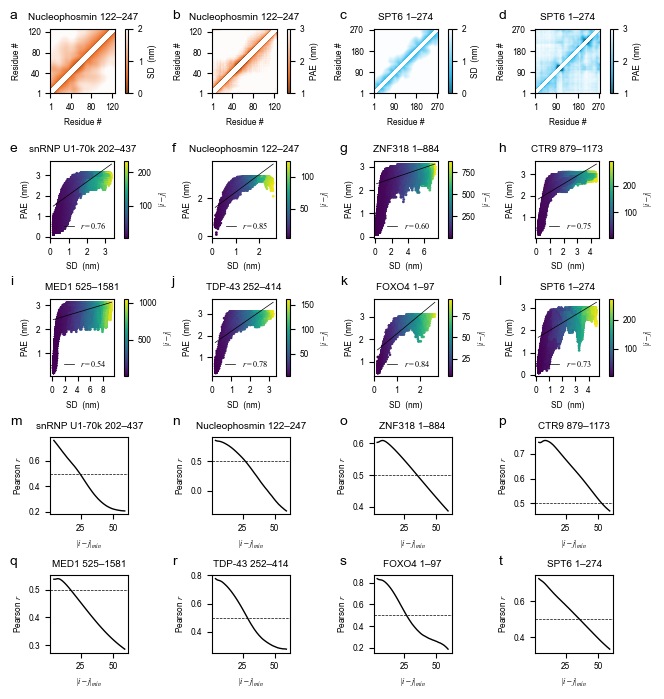

In [6]:
f, axes = plt.subplots(5, 4, sharex=False, sharey=False, figsize=(6.6,7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

proteins = ['P06748_122_247','Q7KZ85_1_274']

labels = ['Nucleophosmin','SPT6']

label_dict = {p: l for p,l in zip(proteins,labels)}

for name,i in zip(df_replicas.loc[proteins].sort_values('nu').index,[0,2]):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_stdev.csv.gz',index_col=0)
    mask_diag = np.tril(np.ones(emap.shape),k=-4).astype(bool)+np.triu(np.ones(emap.shape),k=4).astype(bool)
    emap[~mask_diag] = np.nan
    
    if df_replicas.loc[name].nu <= 0.45:
        cmap = oranges
        color = pt_colors['orange']
        dark_color = dark_orange
    elif df_replicas.loc[name].nu > 0.55:
        cmap = greens
        color = pt_colors['teal']
        dark_color = dark_green
    else:
        cmap = blues
        color = pt_colors['cyan']
        dark_color = dark_blue
    
    cb = plotEnergyMap(axes.flatten()[i],emap,'SD  (nm)',0,2,cmap=cmap,n_ticks=3)
    
    url_string = 'https://alphafold.ebi.ac.uk/files/AF-{:s}-F1-predicted_aligned_error_v4.json'.format(
        df_idrome.loc[name,'UniProt_ID'])
    with urllib.request.urlopen(url_string) as url:
        data = json.load(url)
        first = df_idrome.loc[name,'first']-1
        last = df_idrome.loc[name,'last']
        pae = np.array(data[0]['predicted_aligned_error'])[first:last,first:last]/10
        pae[~mask_diag] = np.nan
        cb = plotEnergyMap(axes.flatten()[i+1],pae,'PAE  (nm)',
                    vmin=1,vmax=3,
                    cmap=cmap,n_ticks=3)
    axes.flatten()[i].set_title(label_dict[name]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))
    axes.flatten()[i+1].set_title(label_dict[name]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))

proteins = ['P08621_202_437','Q5VUA4_1_884','P06748_122_247','Q6PD62_879_1173',
'Q13148_252_414','Q15648_525_1581','Q7KZ85_1_274','P98177_1_97']

labels = ['snRNP U1-70k','ZNF318','Nucleophosmin','CTR9','TDP-43','MED1',
 'SPT6','FOXO4']

label_dict = {p: l for p,l in zip(proteins,labels)}

for name,ax in zip(df_replicas.loc[proteins].sort_values('nu').index,axes.flatten()[4:]):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_stdev.csv.gz',index_col=0)
    ij = np.abs(np.arange(emap.shape[0],dtype=float).reshape(1,-1)-np.arange(emap.shape[0],
                                                                    dtype=float).reshape(-1,1))
    ij_max_range = np.arange(4,60,1) if 60<ij.max() else np.arange(4,ij.max(),2)
    mask_diag = np.tril(np.ones(emap.shape),k=-4).astype(bool)+np.triu(np.ones(emap.shape),k=4).astype(bool)
    emap[~mask_diag] = np.nan
    ij[~mask_diag] = np.nan
    
    mask_diag = ~emap.isnull().values
    emap = emap.values[mask_diag]
    ij = ij[mask_diag]
            
    url_string = 'https://alphafold.ebi.ac.uk/files/AF-{:s}-F1-predicted_aligned_error_v4.json'.format(
        df_idrome.loc[name,'UniProt_ID'])
    with urllib.request.urlopen(url_string) as url:
        data = json.load(url)
        first = df_idrome.loc[name,'first']-1
        last = df_idrome.loc[name,'last']
        pae = np.array(data[0]['predicted_aligned_error'])[first:last,first:last]/10
        
    pae = pae[mask_diag]
    
    
    im = ax.scatter(emap,pae,s=4,marker='o',lw=0,c=ij)#,vmin=1,vmax=100)
    
    x = np.linspace(emap.min(),emap.max(),100)
    pr = pearsonr(emap,pae)[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,emap,pae)
    ax.plot(x,popt[0]*x+popt[1],ls='-',lw=.5,label=f'$r={pr:.2f}$',zorder=4,color='k')

    ax.legend(frameon=False,loc='lower right',handlelength=1.2)
    ax.set_title(label_dict[name]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))
    
    ax.set_xlabel('SD  (nm)')
    
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="{:.1f}%".format(6), pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation='vertical',
                    label=r'$|i-j|$')  
    
    interval = round(x.max()/4,0)
    if interval*4 < x.max():
        ax.set_xticks([0, interval, interval*2, interval*3, interval*4])
    elif interval*3 < x.max():
        ax.set_xticks([0, interval, interval*2, interval*3])
    else:
        ax.set_xticks([0, interval, interval*2])
    
    ax.set_ylabel('PAE  (nm)')
        
for i,name in enumerate(df_replicas.loc[proteins].sort_values('nu').index):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_stdev.csv.gz',index_col=0)
    ij = np.abs(np.arange(emap.shape[0],dtype=float).reshape(1,-1)-np.arange(emap.shape[0],
                                                                    dtype=float).reshape(-1,1))
    ij_max_range = np.arange(4,60,1) if 60<ij.max() else np.arange(4,ij.max(),2)
    
    axes.flatten()[i+12].plot(ij_max_range,corr_coeff[name],lw=1,color='k')
    
    axes.flatten()[i+12].set_xlabel('$|i-j|_{min}$')
    axes.flatten()[i+12].axhline(0.5,lw=.5,ls='--',color='k')
    
    axes.flatten()[i+12].set_title(label_dict[name]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))
    
    axes.flatten()[i+12].set_ylabel('Pearson $r$')
        
f.text(0.01, .97, 'a', fontsize=10)
f.text(0.255, .97, 'b', fontsize=10)
f.text(0.51, .97, 'c', fontsize=10)
f.text(0.75, .97, 'd', fontsize=10)
        
f.text(0.01, .78, 'e', fontsize=10)
f.text(0.255, .78, 'f', fontsize=10)
f.text(0.51, .78, 'g', fontsize=10)
f.text(0.75, .78, 'h', fontsize=10)

f.text(0.01, .59, 'i', fontsize=10)
f.text(0.255, .59, 'j', fontsize=10)
f.text(0.51, .59, 'k', fontsize=10)
f.text(0.75, .59, 'l', fontsize=10)

f.text(0.01, .39, 'm', fontsize=10)
f.text(0.255, .39, 'n', fontsize=10)
f.text(0.51, .39, 'o', fontsize=10)
f.text(0.75, .39, 'p', fontsize=10)

f.text(0.01, .19, 'q', fontsize=10)
f.text(0.255, .19, 'r', fontsize=10)
f.text(0.51, .19, 's', fontsize=10)
f.text(0.75, .19, 't', fontsize=10)

plt.tight_layout()
plt.savefig('figs/ED_fig4.jpg',dpi=600)